In [5]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import math
import networkx as nx
import sys
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [6]:
proj_crs = "EPSG:7855"

## Import Data

Data sources:
1. Shape of Greater Melbourne - used to clip points if not already clipped to the city
2. Points of interest from OSM
3. PTV public transport stops
4. Additional POIs from VicMaps Features of Interest collection
5. Employment data - processed from ABS originally

In [7]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Colouring data & results\\Melbourne Data\\"
data = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\"
Greater_Melbourne = gpd.read_file((folder + 
                                   "Greater_Melbourne_GCCSA_2016.shp")
                                 ).to_crs(proj_crs)

In [8]:
osm_poi_points = gpd.read_file(''.join((data, 
    "OSM-australia-latest-free\\gis_osm_pois_free_1.shp")))
osm_poi_areas = gpd.read_file(data + 
    "OSM-australia-latest-free\\gis_osm_pois_a_free_1.shp")
osm_transport_points = gpd.read_file(data +
    "OSM-australia-latest-free\\gis_osm_transport_free_1.shp")
osm_transport_areas =  gpd.read_file(data +
    "OSM-australia-latest-free\\gis_osm_transport_a_free_1.shp")
osm_parks_vertices = gpd.read_file(''.join((data, 
    "OSM-australia-latest-free\\OSM parks vertices.gpkg")))

Convert polygonal datasets to points and any multipart datasets to single part. Clip OSM data to Greater Melbourne.

In [9]:
osm_pois_2 = single_points(osm_poi_areas)
osm_transport_2 = single_points(osm_transport_areas)
osm_parks_vertices = single_points(osm_parks_vertices)

osm_df = pd.concat([osm_poi_points, osm_pois_2, osm_transport_points, 
                    osm_transport_2, osm_parks_vertices]).to_crs(proj_crs)

osm_df = gpd.clip(osm_df, Greater_Melbourne)

Import PTV data - already clipped to Greater Melbourne area, VicMaps data, and employment data (prepared using Employment points.ipnyb and ABS data).
I have added specific service type columns at this point, even though they will be rolled into 'train' and 'other' for now, to make it easier to change the categories later if desired.

In [10]:
bus = gpd.read_file(folder + "PTV data\\PTV_METRO_BUS_STOP.SHP").assign(fclass='bus')
regional_bus = gpd.read_file(folder + "PTV data\\PTV_REGIONAL_BUS_STOP.SHP").assign(fclass='regional_bus')
tram = gpd.read_file(folder + "PTV data\\PTV_METRO_TRAM_STOP.SHP").assign(fclass='tram')
coach = gpd.read_file(folder + "PTV data\\PTV_REGIONAL_COACH_STOP.SHP").assign(fclass='coach')
train = gpd.read_file(folder + "PTV data\\PTV_REGIONAL_TRAIN_STATION.SHP").assign(fclass='regional_train')
regional_train = gpd.read_file(folder + "PTV data\\PTV_METRO_TRAIN_STATION.SHP").assign(fclass='train')

PTV = pd.concat([bus, regional_bus, tram, coach, train, regional_train]).to_crs(proj_crs)

In [11]:
vicmaps_points = gpd.read_file(folder + "VicMap Features of Interest\\FOI_POINT.shp")
vicmaps_areas = gpd.read_file(folder + "VicMap Features of Interest\\VMFOI.gdb")

vicmaps = pd.concat([vicmaps_points, vicmaps_areas]).to_crs(proj_crs)

vicmaps = gpd.clip(vicmaps, Greater_Melbourne)

In [68]:
employment_centrs = gpd.read_file(folder + "Vic_Employment_meshblocks.gpkg").to_crs(proj_crs)

### Categorise and weight POIs

Categorise POI data - change classes depending on your analysis and your data sources.

In [13]:
metro_categories = {'transport':['bus', 'regional_bus', 'tram'], 
                    'trains':['train', 'regional_train', 'coach']}

metro_categorised = categorise_pois(PTV, metro_categories, 
                                 category_column='fclass')

Tags present in the dataset but not categorised:
[]


In [14]:
osm_categories = {"eating" : ['restaurant', 'pub', 'cafe', 'fast_food', 
                              'food_court', 'bakery', 'bar', 'nightclub', 'biergarten'], 
                  'groceries' : ['supermarket', 'chemist', 'pharmacy', 'greengrocer', 
                                 'convenience', 'butcher', 'beverages', 'alcohol'], 
                  'shopping' : ['mall', 'bicycle_shop', 'clothes', 
                                'department_store', 'doityourself', 
                                'outdoor_shop', 'stationery', 'bookshop', 
                                'gift_shop', 'newsagent', 'car_dealership', 
                                'kiosk', 'furniture_shop', 'sports_shop', 
                                'garden_centre', 'computer_shop', 'shoe_shop', 
                                'beauty_shop', 'florist', 'video_shop', 'toy_shop', 
                                'mobile_phone_shop', 'jeweller', 'travel_agent'], 
                  'errands' : ['post_box', 'post_office', 'bank', 'atm',
                               'doctors', 'dentist', 'laundry', 'hospital',
                               'car_wash', 'veterinary', 'hairdresser', 'optician'], 
                  'parks' : ['viewpoint', 'park', 'playground', 'picnic_site', 
                             'pitch', 'swimming_pool', 'sports_centre', 
                             'golf_course', 'track', 'dog_park'], 
                  'education' : ['college', 'school', 'kindergarten', 'university'], 
                  'entertainment' : ['library', 'attraction', 'stadium', 
                                     'arts_centre', 'theatre', 'artwork', 
                                     'archaeological', 'cinema', 'museum', 
                                     'ruins', 'observation_tower', 
                                     'community_centre', 'zoo', 'castle', 
                                     'theme_park', 'ice_rink'], 
                 'trains' : ['ferry_terminal', 'railway_station', 'bus_station', 
                             'tram_stop', 'railway_halt', 'publictransport'], 
                 'transport' : ['car_sharing', 'bus_stop']}

osm_categorised = categorise_pois(osm_df, osm_categories, 
                                  category_column='fclass')

Tags present in the dataset but not categorised:
['toilet' 'bench' 'drinking_water' 'shelter' 'camp_site' 'monument'
 'memorial' 'fire_station' 'telephone' 'tourist_info' 'hunting_stand'
 'camera_surveillance' 'waste_basket' 'motel' 'caravan_site' 'graveyard'
 'fountain' 'guesthouse' 'water_tower' 'tower' 'police' 'public_building'
 'vending_any' 'hotel' 'nursing_home' 'comms_tower' 'vending_parking'
 'recycling' 'lighthouse' 'wastewater_plant' 'bicycle_rental'
 'bed_and_breakfast' 'courthouse' 'town_hall' 'car_rental'
 'vending_machine' 'taxi' 'hostel' 'water_well' 'water_works'
 'recycling_clothes' 'recycling_glass' 'chalet' 'prison' 'embassy'
 'recycling_paper' 'alpine_hut']


In the VicMaps data, the 'community space' collection is caravan parks, camping areas (generally outside Greater Melbourne) and rest areas, not considered relevant. The 'community venue' collection is community centres, halls, senior clubs, scouts etc.

In [15]:
vicmaps_categories = {"eating" : [], 
                  'groceries' : [], 
                  'shopping' : [], 
                  'errands' : ['hospital', 'health facility', 'place of worship'], 
                  'parks' : ['recreational resource', 'reserve','sport facility'], 
                  'education' : ['education centre'], 
                  'entertainment' : ['cultural centre', 'commercial facility', 'community venue'], 
                 'trains' : [], 
                 'transport' : []}


vicmaps_categorised = categorise_pois(vicmaps, vicmaps_categories, 
                                  category_column='FTYPE')

Tags present in the dataset but not categorised:
['sign' 'landmark' 'care facility' 'emergency facility'
 'communication service' nan 'community space' 'admin facility'
 'dumping ground' 'control point' 'excavation site' 'place'
 'storage facility' 'pipeline facility' 'defence site']


Need to remove potential overlap between different data sources (and inside some data sources). For this dataset it's around 30% because there is overlap of public transport stops between OSM and transport agencies, and overlap of places like parks and schools between OSM and VicMaps. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [16]:
pois = remove_duplicate_pois([osm_categorised, vicmaps_categorised,
                              metro_categorised], buffer=10)

pois = gpd.clip(pois, Greater_Melbourne)

Removed 35.67% duplicate points from dataframes


Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [17]:
poi_weights = {
    "employment": [10],
    "eating": [3, 3, 3, 2, 2, 1, 1, 1, 1, 1],
    "groceries": [10, 4],
    "shopping": [2, 2, 2, 2, 2],
    "errands": [6, 2, 4],
    "parks": [6],
    "education": [10],
    "entertainment": [5],
    "trains": [10],
    "transport": [2.5, 2.5]
}

In [18]:
category_sums = {k: sum(v) for k, v in poi_weights.items()}
total = sum(category_sums.values())
print(category_sums)
print("total: ", total)

{'employment': 10, 'eating': 18, 'groceries': 14, 'shopping': 10, 'errands': 12, 'parks': 6, 'education': 10, 'entertainment': 5, 'trains': 10, 'transport': 5.0}
total:  100.0


### Import network

In this case the network is already in the same projected CRS as everything else but I have left in the transformation to be clear.

In [ ]:
# reading directly with geopandas.read_file crashes on my computer so I read into pandas then convert to gdf instead
edges_df = pd.read_csv(folder + "melbourne_edges.csv")
nodes_df = pd.read_csv(folder + "melbourne_nodes.csv")

In [119]:
edges = gpd.GeoDataFrame(edges_df, 
                         geometry=gpd.GeoSeries.from_wkt(edges_df['geometry'])).set_crs("EPSG:7856")
nodes = gpd.GeoDataFrame(nodes_df, 
                         geometry=gpd.GeoSeries.from_wkt(nodes_df['geometry'])).set_crs("EPSG:7856")
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

<class 'str'>
<class 'str'>


Pandana expects edges to have a two item index based on the same IDs as the node index.

In [120]:
nodes.set_index('connect_id',inplace=True)   #do not assume this is the case if it is not

edges['from_idx'] = edges['from']
edges['to_idx'] = edges['to']
edges= edges.set_index(['from_idx', 'to_idx'])
edges.index.names= ['from_idx','to_idx']

In [121]:
edges = edges[edges['to'].isin(nodes.index) & edges['from'].isin(nodes.index)]

Pandana network creation.

In [123]:
distance_network = pdna.Network(nodes['geometry'].x, nodes['geometry'].y,
                                   edges['from'], edges['to'], 
                                   edges[['length']])

maximum_dist = 2400

Pandana network querying. The 'employment' category is empty because we didn't add the employment points to the POI dataset.

In [124]:
results = walk_index(distance_network, pois, poi_weights, distance=maximum_dist)

Category employment is empty
Finished category: eating
Finished category: groceries
Finished category: shopping
Finished category: errands
Finished category: parks
Finished category: education
Finished category: entertainment
Finished category: trains
Finished category: transport


In [126]:
results.to_csv("Melbourne_colournoemployment_020522.csv")

### Employment

The current approach is to find up to 100 closest employment nodes within the maximum distance. Then look up the number of jobs at each one, apply a distance decay function to each distance, multiply these together, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter. The aggregate function also seems to be slower than expected with the kind of network & distances I use.

In [69]:
employment_centrs = single_points(employment_centrs)

In [72]:
employment_centrs = employment_centrs.droplevel(1, axis=0)
employment_centrs=employment_centrs.set_index('Jobs')

In [128]:
x, y = (employment_centrs['geometry'].x, employment_centrs['geometry'].y)

distance_network.set_pois(category='employment', maxdist=maximum_dist, maxitems=100, x_col=x, y_col=y)

employment_access = distance_network.nearest_pois(
    distance=maximum_dist, category='employment', num_pois=100, include_poi_ids=True)

jobcounts = employment_access.iloc[:,100:200]

In [ ]:
results['jobs'] = ((employment_access.iloc[:,0:100].applymap(access_weight, distance=maximum_dist))*
                                jobcounts.values
                                ).sum(axis=1)

weight = 100*poi_weights['employment'][0]/sum(sum(list(poi_weights.values()),[]))

In [141]:
results['Walk_Index'] = results['Walk_Index'] - results['employment']

In [142]:
results['employment'] = [weight*min(x/70000,1) for x in results['jobs']]

results['Walk_Index'] = results['Walk_Index'] + results['employment']

In [143]:
max(results['employment'])

10.0

## Export results

Filter the results to the original Colouring Sydney buildings only. Optionally export results as a csv.

In [144]:
building_results = results.filter(items=nodes[nodes['connect_type'] == 'poi'].index, axis=0)

In [145]:
building_results.to_csv("Colouring_bf_results_020522_2.csv")

In [159]:
building_results.iloc[:,3:41] = building_results.iloc[:,3:41].round(1)

In [160]:
building_results.to_csv("Colouring_bf_results_020522_round.csv")

In [146]:
results_gdf = gpd.GeoDataFrame(building_results, geometry = gpd.GeoSeries.from_xy(building_results.x, building_results.y, crs="EPSG:7856"))

In [147]:
results_gdf.to_file("Colouring_results_020522_2.gpkg")

Import building footprints and join the data to them, then export these polygons.

In [148]:
buildings_foot = gpd.read_file(folder + "melbourne_bf.shp").to_crs(proj_crs)

# join to data
buildings_foot = gpd.sjoin(buildings_foot, results_gdf, how='left', predicate='contains')

buildings_foot.to_file("Colouring_bf_results_180221.gpkg")

<ipython-input-148-5a3ac130696b>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:7855
Right CRS: EPSG:7856

  buildings_foot = gpd.sjoin(buildings_foot, results_gdf, how='left', predicate='contains')


In [94]:
import matplotlib.pyplot as plt

In [96]:
nodes.geometry.total_bounds

array([ 264815.63445951, 5736826.24741635,  401218.83808026,
       5883216.8258106 ])

In [101]:
results_gdf.geometry.total_bounds

array([ 265262.52912627, 5737114.44708126,  396710.7335429 ,
       5882782.30703949])

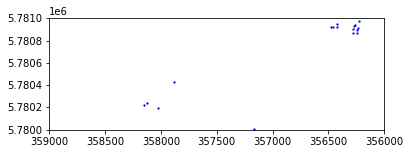

In [103]:
minx, miny, maxx, maxy = results_gdf.geometry.total_bounds

f, ax = plt.subplots()
#features.plot(ax=ax, color='red')
results_gdf.plot(ax=ax, marker='o', color='blue', markersize=1.5, c = results_gdf['Walk_Index'], cmap = 'magma')

ax.set_xlim(359000, 356000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(5780000, 5781000)
plt.show()

In [105]:
results_gdf.loc[2528573]

x                                                317187.970543
y                                               5752248.322267
employment_10                                                0
eating1                                            2146.012939
eating2                                                 2400.0
eating3                                                 2400.0
eating4                                                 2400.0
eating5                                                 2400.0
eating6                                                 2400.0
eating7                                                 2400.0
eating8                                                 2400.0
eating9                                                 2400.0
eating10                                                2400.0
eating_18                                             0.350849
groceries1                                         1618.662964
groceries2                                             

In [111]:
edges[edges['from'] == 2528573]

,,Unnamed: 0,maxspeed,layer,ref,fclass,osm_id,fid,ShpName,bridge,tunnel,oneway,name,geometry,length,to,from,connect_id,key,connect_type,poi_id
from_idx,to_idx,,,,,,,,,,,,,,,,,,,,
2528573,603201,4598040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,"LINESTRING (341674.959 5788244.209, 341617.621...",75.951916,603201,2528573,2528573_4184430,907828.0,projected_footway,NaN


In [107]:
nodes.loc[2528573]

Unnamed: 0                                               2528573
geometry             POINT (317187.9705430298 5752248.322267163)
connect_id                                               2689072
Shape_Leng                                              0.000233
Shape_Area                                                   0.0
key                                                    1068327.0
connect_type                                                 poi
x                                                  -207546.77823
y                                                  5723195.42908
UFI                                                          NaN
PFI                                                          NaN
FEATURE_ID                                                   NaN
PARENTFTID                                                   NaN
FTYPE                                                        NaN
FEATSUBTYP                                                   NaN
FEATSTATUS               